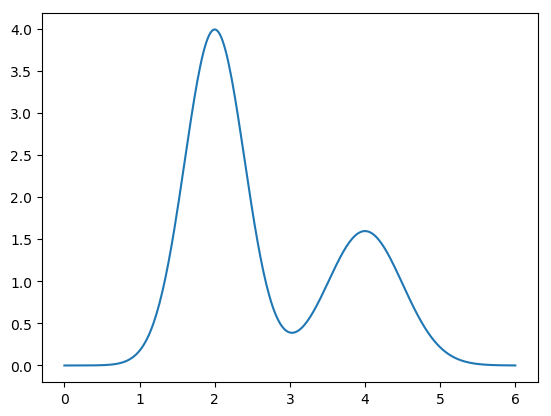

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x199ab6fd0>

In [1]:
using PyCall
include("../src/gauss_error.jl")
include("../src/kernels.jl")
include("../src/mcmc.jl")

a = 0.
b = 6.

function phi(x::Float64)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5

    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

x = collect(range(a, stop=b, length=300))

import PyPlot.plot
myplot = plot(x, phi.(x))

In [2]:
kernel_name = "triangular"

function kernel(x::Float64, y::Float64)
    return getOpticsKernels(kernel_name)(x, y)
end

kernel (generic function with 1 method)

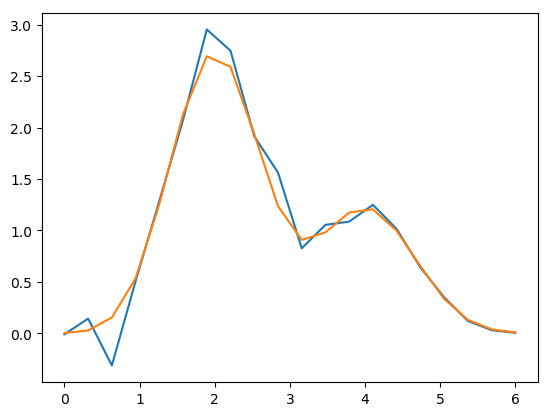

[0.0032054, 0.0285085, 0.154328, 0.534167, 1.25699, 2.1284, 2.69259, 2.59001, 1.93769, 1.23665, 0.908598, 0.981725, 1.17397, 1.20528, 0.996678, 0.653962, 0.335774, 0.13228, 0.0390623, 0.00842025]



In [3]:
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]
y = collect(range(a, stop=b, length=20))
ftrue = convolution.(y)
sig = 0.05*ftrue + [0.01 for i = 1:Base.length(ftrue)]
using Compat, Random, Distributions
noise = []
Random.seed!(1234)
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end

const_sig = [-0.01261988076481369, 0.11549222383853759, -0.46621847536331, -0.027254387627552102, 0.03065511435482842, -0.05435612148005363, 0.2604677397058683, 0.1565930441161031, -0.02176112453218068, 0.3259096052065758, -0.08200256535971161, 0.07268039882059657, -0.08810335857089219, 0.043810151147082615, 0.018032974081921074, -0.01322823199373628, 0.015293716559492491, -0.010829962058481626, -0.007877576791090336, -0.0025713120114854845]

noise = const_sig
println(ftrue)
f = ftrue + noise
plot(y, f)
plot(y, ftrue)
println()

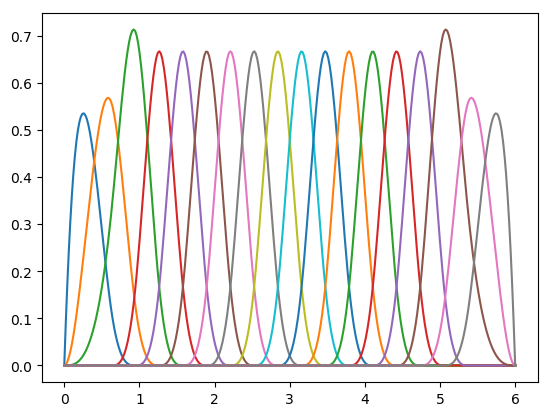

┌ Info: Cubic spline basis is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:258


In [4]:
knots = y
basis = CubicSplineBasis(knots, ("dirichlet", "dirichlet"))

for func in basis.basis_functions
    plot(x, func.f.(x))
end

In [5]:
using PyPlot

Omega = omega(basis, 2)
print()

┌ Info: Calculating omega matrix for Cubis spline basis derivatives of order 2...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:266
┌ Info: Omega caclulated successfully.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:285


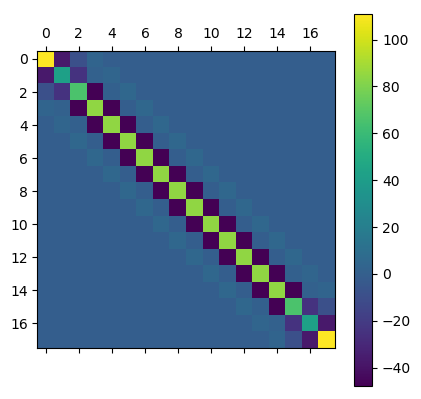

PyObject <matplotlib.colorbar.Colorbar object at 0x19a2d40f0>

In [6]:
matshow(Omega)
colorbar()

In [7]:
model = GaussErrorUnfolder(basis, [Omega], "EmpiricalBayes", nothing, [1e-8], [10.], [0.3])
println()

┌ Info: GaussErrorMatrixUnfolder is created
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:63
┌ Info: GaussErrorUnfolder is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:167


In [8]:
phi_reconstruct = solve(model, kernel, f, sig, y)

┌ Info: Starting solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:200
┌ Info: Starting discretize kernel...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:51
┌ Info: Kernel was discretized successfully.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:62
┌ Info: Starting solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:93
┌ Info: Starting find_optimal_alpha...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/check.jl:124
┌ Info: Starting optimization...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/check.jl:149


Iter     Function value   Gradient norm 
     0    -2.978556e+02     8.921068e+00
     1    -3.003456e+02     5.899933e+00
     2    -3.065180e+02     1.771293e-01
     3    -3.065224e+02     8.015703e-05
     4    -3.065224e+02     1.289836e-08
     5    -3.065224e+02     5.732605e-09


┌ Info: Optimized successfully, alphas = [0.0378168].
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/check.jl:164
┌ Info: Ending solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:111
┌ Info: Ending solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:208


Dict{String,Array{Float64,N} where N} with 3 entries:
  "errors" => [0.140613 -0.0602985 … 2.18376e-5 -5.43401e-5; -0.0602985 0.19677…
  "alphas" => [0.0378168]
  "coeff"  => [0.144654, -0.330102, -0.316021, 0.852788, 2.53327, 3.55409, 3.32…

In [9]:
phivec = PhiVec(phi_reconstruct["coeff"], basis, phi_reconstruct["errors"])
println()

┌ Info: PhiVec is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/vector.jl:69


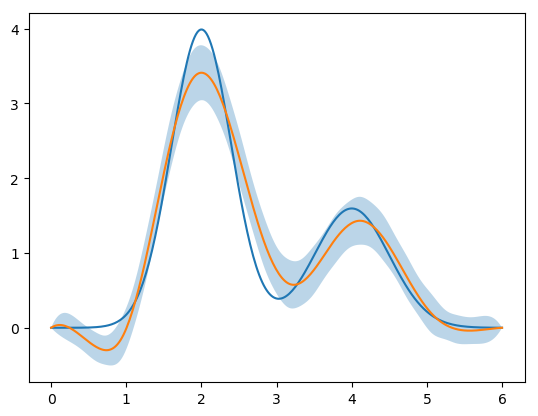

PyObject <matplotlib.collections.PolyCollection object at 0x19a34ee48>

In [10]:
using PyPlot

plot(x, phi.(x))
# title(kernel_name + "kernel")
phi_reconstructed = phivec.phi_function.(x)
phi_reconstructed_errors = phivec.error_function.(x)
println()

plot(x, phi_reconstructed)
fill_between(x, phi_reconstructed - phi_reconstructed_errors, phi_reconstructed + phi_reconstructed_errors, alpha=0.3)

In [11]:
model_mcmc = MCMCUnfolder(basis, [Omega], "EmpiricalBayes", nothing, [1e-5], [10.], [0.5])
println()

┌ Info: MCMCMatrixUnfolder is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:65
┌ Info: MCMCUnfolder is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:235


In [12]:
model_, line, inits, samples, burnin, thin, chains = solve(model_mcmc, discretize_kernel(basis, kernel, y), f, sig, nothing, 1, 10000)
sim = mcmc(model_, line, inits, samples, burnin=burnin, thin=thin, chains=chains)
res = get_values(sim, chains, length(basis))
println()

┌ Info: Starting discretize kernel...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:51
┌ Info: Kernel was discretized successfully.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:62


Iter     Function value   Gradient norm 
     0    -2.927252e+02     1.106383e+01
     1    -3.057270e+02     2.326208e+00
     2    -3.065218e+02     6.630007e-02
     3    -3.065224e+02     2.287309e-06
     4    -3.065224e+02     8.598907e-09


┌ Info: Starting solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:274
┌ Info: Starting solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:104
┌ Info: Starting find_optimal_alpha...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/check.jl:124
┌ Info: Starting optimization...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/check.jl:149
┌ Info: Optimized successfully, alphas = [0.0378168].
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/check.jl:164
┌ Info: Ending solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:120
┌ Info: Starting solve_MCMC...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:132
┌ Info: Ending solve_MCMC...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:155
┌ Info: Ending solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:283


MCMC Simulation of 10000 Iterations x 1 Chain...

Chain 1:   0% [0:20:39 of 0:20:40 remaining]
Chain 1:  10% [0:00:33 of 0:00:37 remaining]
Chain 1:  20% [0:00:23 of 0:00:29 remaining]
Chain 1:  30% [0:00:19 of 0:00:27 remaining]
Chain 1:  40% [0:00:15 of 0:00:26 remaining]
Chain 1:  50% [0:00:12 of 0:00:25 remaining]
Chain 1:  60% [0:00:10 of 0:00:24 remaining]
Chain 1:  70% [0:00:07 of 0:00:24 remaining]
Chain 1:  80% [0:00:05 of 0:00:24 remaining]
Chain 1:  90% [0:00:02 of 0:00:24 remaining]
Chain 1: 100% [0:00:00 of 0:00:24 remaining]



UndefVarError: UndefVarError: errors not defined

In [13]:
phivec_mcmc = PhiVec(res, basis)
phi_reconstructed_mcmc = phivec_mcmc.phi_function.(x)
phi_reconstructed_mcmc_errors = phivec_mcmc.error_function.(x)
plot(x, phi.(x))
plot(x, phi_reconstructed, "g")
fill_between(x, phi_reconstructed - phi_reconstructed_errors, phi_reconstructed + phi_reconstructed_errors, alpha=0.3)
plot(x, phi_reconstructed_mcmc, "r")
fill_between(x, phi_reconstructed_mcmc - phi_reconstructed_mcmc_errors, phi_reconstructed_mcmc + phi_reconstructed_mcmc_errors, alpha=0.3)


UndefVarError: UndefVarError: res not defined